In [752]:
import sys
import os

import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pylab as plt
from scipy.spatial.distance import squareform
from numba import njit, prange
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from scipy import stats

sns.set_style('ticks')
sns.set_context('talk')

# Read Suite2p output.

In [753]:
#change folder path where data are stored
FOLDER_PATH = "/Volumes/WD_BLACK/Simon/20210820_phase4/664/suite2p/plane2"

odorPath = '/Volumes/S_Zeppilli2/SIMON/20210820_phase4/664/664_Odor_series.mat'

xmlPath = '/Volumes/S_Zeppilli2/SIMON/20210820_phase4/664/TSeries-08182021-1051-001/TSeries-08182021-1051-001.xml'

saveDataFramePath = '/Volumes/WD_BLACK/Simon/20210820_phase4/664/Analysis/Plane_2'


In [754]:
path1 = os.path.join(FOLDER_PATH, "F.npy")
path2 = os.path.join(FOLDER_PATH, "Fneu.npy")
path3 = os.path.join(FOLDER_PATH, "F_chan2.npy")
path4 = os.path.join(FOLDER_PATH, "Fneu_chan2.npy")
path5 = os.path.join(FOLDER_PATH, "spks.npy")
path6 = os.path.join(FOLDER_PATH, "iscell.npy")
path7 = os.path.join(FOLDER_PATH, "stat.npy")

traces = np.load(path1)
neu = np.load(path2)
trace_red = np.load(path3)
neu_red = np.load(path4)
spks = np.load(path5)
ithisaCellBinary = np.load(path6)
stat_dict = np.load(path7, allow_pickle = True)[0]

In [755]:
traces.shape

(314, 16000)

In [756]:
# define some arguments for later:
numCells, numFramesTotal = traces.shape
numFramesOdorTrial = 100
numOdors = 4
numTrials = 160
numOdorTrials = 160

# Read in odor sequence information.

In [757]:
import scipy.io
mat = scipy.io.loadmat(odorPath)

a = mat['outs_sorted'][:]
odorID = a[:,1]
len(odorID)

160

In [758]:
odorID = a[0:160,1]
trialOdorArray = odorID

 # Read in Prairie output for metadata. 

In [759]:
from xml.dom import minidom
doc = minidom.parse(xmlPath)
sequence = doc.getElementsByTagName('Sequence')
numFrames_XML = len(sequence)

# is number of suite2p frames equal to the number of xml frames?
print(f'correct number of frames: {numFramesTotal==numFrames_XML}')
print(f'Number of trial: {numFrames_XML/100}')

correct number of frames: True
Number of trial: 160.0


In [760]:
numFramesTotal

16000

In [761]:
# get xmlFrameIDS, framePeriods, relativeTimes, absoluteTimes. 
#These values are specific to each experiment. 
#We assume there is a 1 to 1 correspondence between xml frames and suite2p frames

def getMetaDataFromXML(sequence,numFrames_XML):
    """
    Returns: xml Frame ID,
    duration of each Frame in seconds,
    relative time, 
    absolute time
    """
    framePeriods = []
    relativeTimes = []
    absoluteTimes = []
    xmlFrameIDS = []
    for xmlFrame in range(numFrames_XML):
        subFrames = sequence[xmlFrame].getElementsByTagName('Frame')
        xmlFrameID = int(sequence[xmlFrame].getAttribute('cycle'))

        #for each xml sequence there are 3 subfields called Frame. Each one  has a framePeriod associated with it. Add these to get the total time for each sequence.
        framePeriod = 0
        for subframe in subFrames:
            a = subframe.getElementsByTagName('PVStateValue')[0]
            framePeriod+=float(a.attributes.items()[1][1])

            # for the last subframe, get the relative and absolute times. 
        lastFrame = subFrames[2]
        relativeTime = float(lastFrame.getAttribute('relativeTime'))
        absoluteTime = float(lastFrame.getAttribute('absoluteTime'))

        framePeriods.append(framePeriod)
        relativeTimes.append(relativeTime)
        absoluteTimes.append(absoluteTime)
        xmlFrameIDS.append(xmlFrameID)
    return xmlFrameIDS, framePeriods, relativeTimes, absoluteTimes

xmlFrameIDS, framePeriods, relativeTimes, absoluteTimes = getMetaDataFromXML(sequence,numFrames_XML)

# On a cell by cell basis, populate the master dataframe.

In [762]:
dfsAllCells = []
for cell in range(numCells):
    dfOneCell = pd.DataFrame(dict(xmlFrameID = xmlFrameIDS,
                                    suite2pFrameID = None, 
                                    framePeriod = framePeriods,
                                    frameRate = 1/np.array(framePeriods),
                                    relativeTime = relativeTimes,
                                    absoluteTime = absoluteTimes,
                                    cellID = cell,
                                    F = traces[cell,:],
                                    Fneu = neu[cell,:],
                                    F_red = trace_red[cell,:],
                                    Fneu_red = neu_red[cell,:],
                                    deconv = spks[cell,:],
                                    odorID = None, # the actual odorID in this position.
                                    trialID = None,
                                    cellProbBinary = ithisaCellBinary[cell][0],
                                    cellProbRaw = ithisaCellBinary[cell][1],

                                ))

    odorTrialID = 0
    for trialID in range(len(trialOdorArray)):
        trialOdorFrameRange = np.s_[numFramesOdorTrial*odorTrialID:numFramesOdorTrial*odorTrialID +numFramesOdorTrial]
            # for column indexing below, I need to provide the index corresponding to the name of each column, hence: list(dfOnceCell.columns).index(columnName)
        dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('suite2pFrameID')] = range(numFramesOdorTrial) #assign frame id to each odor-trial
        dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('trialID')] = trialID
        dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('odorID')] = trialOdorArray[trialID] # index to specific trial-odor id. 
        odorTrialID+=1
    dfsAllCells.append(dfOneCell)
    
# combine all cells into one Dataframe
DF = pd.concat(dfsAllCells,axis=0)
#subtract neuropil
DF['Fadj'] = DF.F- 0.7*DF.Fneu
DF['Fadj_red'] = DF.F_red- 0.7*DF.Fneu_red

In [763]:
print ('DF fields:\n')
print (list(DF.columns))
DF

DF fields:

['xmlFrameID', 'suite2pFrameID', 'framePeriod', 'frameRate', 'relativeTime', 'absoluteTime', 'cellID', 'F', 'Fneu', 'F_red', 'Fneu_red', 'deconv', 'odorID', 'trialID', 'cellProbBinary', 'cellProbRaw', 'Fadj', 'Fadj_red']


xmlFrameID suite2pFrameID  framePeriod  frameRate  relativeTime  \
0               1              0     0.221194   4.520927      0.147462   
1               2              1     0.221194   4.520927      0.368656   
2               3              2     0.221194   4.520927      0.589850   
3               4              3     0.221194   4.520927      0.811043   
4               5              4     0.221194   4.520927      1.032237   
...           ...            ...          ...        ...           ...   
15995       15996             95     0.221193   4.520931     21.160833   
15996       15997             96     0.221193   4.520931     21.382026   
15997       15998             97     0.221193   4.520931     21.603219   
15998       15999             98     0.221193   4.520931     21.824413   
15999       16000             99     0.221193   4.520931     22.045606   

       absoluteTime  cellID           F        Fneu       F_red    Fneu_red  \
0         58.417462       0  672.911987  632.506836  674.860168  525.806274   
1         58.638656       0  688.270386  640.362061  482.238373  526.489258   
2         58.859850       0  680.464111  621.526428  564.033936  552.258301   
3         59.081043       0  666.538269  620.718201  523.442993  553.236816   
4         59.302237       0  644.228394  619.262207  465.608093  528.557739   
...             ...     ...         ...         ...         ...         ...   
15995   5158.364833     313  606.984497  588.593018  358.904816  483.091095   
15996   5158.586026     313  594.780457  583.767456  407.783691  453.459290   
15997   5158.807219     313  611.660706  583.211243  400.208984  480.011627   
15998   5159.028413     313  562.188843  575.934082  312.606750  442.560089   
15999   5159.249606     313  587.422241  582.722839  438.537964  439.794586   

          deconv odorID trialID  cellProbBinary  cellProbRaw        Fadj  \
0       0.000000      2       0             1.0     0.856250  230.157202   
1      18.546329      2       0             1.0     0.856250  240.016943   
2      14.055822      2       0             1.0     0.856250  245.395612   
3       0.000000      2       0             1.0     0.856250  232.035529   
4       0.000000      2       0             1.0     0.856250  210.744849   
...          ...    ...     ...             ...          ...         ...   
15995   0.808291      4     159             1.0     0.963888  194.969385   
15996   0.000000      4     159             1.0     0.963888  186.143237   
15997   4.350206      4     159             1.0     0.963888  203.412836   
15998   0.000000      4     159             1.0     0.963888  159.034985   
15999   0.000000      4     159             1.0     0.963888  179.516254   

         Fadj_red  
0      306.795776  
1      113.695892  
2      177.453125  
3      136.177222  
4       95.617676  
...           ...  
15995   20.741049  
15996   90.362189  
15997   64.200845  
15998    2.814688  
15999  130.681754  

[5024000 rows x 18 columns]

# Sort the dataframe based on cellID then odorID

In [764]:
DFsorted = DF.sort_values(['cellID', 'odorID'])
DFsorted

xmlFrameID suite2pFrameID  framePeriod  frameRate  relativeTime  \
0               1              0     0.221194   4.520927      0.147462   
1               2              1     0.221194   4.520927      0.368656   
2               3              2     0.221194   4.520927      0.589850   
3               4              3     0.221194   4.520927      0.811043   
4               5              4     0.221194   4.520927      1.032237   
...           ...            ...          ...        ...           ...   
15595       15596             95     0.221194   4.520923     21.160872   
15596       15597             96     0.221194   4.520923     21.382066   
15597       15598             97     0.221194   4.520923     21.603260   
15598       15599             98     0.221194   4.520923     21.824454   
15599       15600             99     0.221194   4.520923     22.045648   

       absoluteTime  cellID           F        Fneu       F_red    Fneu_red  \
0         58.417462       0  672.911987  632.506836  674.860168  525.806274   
1         58.638656       0  688.270386  640.362061  482.238373  526.489258   
2         58.859850       0  680.464111  621.526428  564.033936  552.258301   
3         59.081043       0  666.538269  620.718201  523.442993  553.236816   
4         59.302237       0  644.228394  619.262207  465.608093  528.557739   
...             ...     ...         ...         ...         ...         ...   
15595   5029.685872     313  579.488953  533.926331  386.393890  437.294586   
15596   5029.907066     313  562.857300  540.563965  409.790588  451.441864   
15597   5030.128260     313  563.873718  536.548462  410.840240  465.447662   
15598   5030.349454     313  543.516052  536.060059  343.654602  481.426361   
15599   5030.570648     313  551.594360  535.976746  387.124146  464.492249   

          deconv odorID trialID  cellProbBinary  cellProbRaw        Fadj  \
0       0.000000      2       0             1.0     0.856250  230.157202   
1      18.546329      2       0             1.0     0.856250  240.016943   
2      14.055822      2       0             1.0     0.856250  245.395612   
3       0.000000      2       0             1.0     0.856250  232.035529   
4       0.000000      2       0             1.0     0.856250  210.744849   
...          ...    ...     ...             ...          ...         ...   
15595   8.495939      5     155             1.0     0.963888  205.740521   
15596   0.000000      5     155             1.0     0.963888  184.462524   
15597   0.000000      5     155             1.0     0.963888  188.289795   
15598   0.000000      5     155             1.0     0.963888  168.274011   
15599   0.000000      5     155             1.0     0.963888  176.410638   

         Fadj_red  
0      306.795776  
1      113.695892  
2      177.453125  
3      136.177222  
4       95.617676  
...           ...  
15595   80.287680  
15596   93.781284  
15597   85.026877  
15598    6.656149  
15599   61.979572  

[5024000 rows x 18 columns]

# Create 3D array for each odor - durty

In [765]:
numCells = DF["cellID"].iloc[-1]+1
numOdors = 4
numOdorTrials = 160

In [766]:
odorparse = 2

DataArray_Fadj =[]
DataArray_Fadj_Fluo=[]
DataArray_Fadj_odor_2 = []
DataArray_Fadj_Fluo_odor_2 = []
DataArray_Fadj_Fluo_red_odor_2 = []
for cell in range(numCells):
    mf_1 = DFsorted['odorID'] == odorparse
    mf_2 = DFsorted['cellID'] == cell
    Fadj_trace = DFsorted.loc[mf_1 & mf_2,'Fadj'].values
    Fadj_trace_red = DFsorted.loc[mf_1 & mf_2,'Fadj_red'].values

    Fadj_trace_scale=scale(Fadj_trace)
    DataArray_Fadj.append(Fadj_trace_scale.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo.append(Fadj_trace.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo_red_odor_2.append(Fadj_trace_red.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
DataArray_Fadj_odor_2 = np.concatenate(DataArray_Fadj,0)
DataArray_Fadj_Fluo_odor_2 = np.concatenate(DataArray_Fadj_Fluo,0)
DataArray_Fadj_Fluo_red_odor_2 = np.concatenate(DataArray_Fadj_Fluo_red_odor_2,0)

In [767]:
odorparse = 3

DataArray_Fadj =[]
DataArray_Fadj_Fluo=[]
DataArray_Fadj_odor_3 = []
DataArray_Fadj_Fluo_odor_3 = []
DataArray_Fadj_Fluo_red_odor_3 = []
for cell in range(numCells):
    mf_1 = DFsorted['odorID'] == odorparse
    mf_2 = DFsorted['cellID'] == cell
    Fadj_trace = DFsorted.loc[mf_1 & mf_2,'Fadj'].values
    Fadj_trace_red = DFsorted.loc[mf_1 & mf_2,'Fadj_red'].values

    Fadj_trace_scale=scale(Fadj_trace)
    DataArray_Fadj.append(Fadj_trace_scale.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo.append(Fadj_trace.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo_red_odor_3.append(Fadj_trace_red.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
DataArray_Fadj_odor_3 = np.concatenate(DataArray_Fadj,0)
DataArray_Fadj_Fluo_odor_3 = np.concatenate(DataArray_Fadj_Fluo,0)
DataArray_Fadj_Fluo_red_odor_3 = np.concatenate(DataArray_Fadj_Fluo_red_odor_3,0)

In [768]:
odorparse = 4

DataArray_Fadj =[]
DataArray_Fadj_Fluo=[]
DataArray_Fadj_odor_4 = []
DataArray_Fadj_Fluo_odor_4 = []
DataArray_Fadj_Fluo_red_odor_4 = []
for cell in range(numCells):
    mf_1 = DFsorted['odorID'] == odorparse
    mf_2 = DFsorted['cellID'] == cell
    Fadj_trace = DFsorted.loc[mf_1 & mf_2,'Fadj'].values
    Fadj_trace_red = DFsorted.loc[mf_1 & mf_2,'Fadj_red'].values

    Fadj_trace_scale=scale(Fadj_trace)
    DataArray_Fadj.append(Fadj_trace_scale.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo.append(Fadj_trace.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo_red_odor_4.append(Fadj_trace_red.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
DataArray_Fadj_odor_4 = np.concatenate(DataArray_Fadj,0)
DataArray_Fadj_Fluo_odor_4 = np.concatenate(DataArray_Fadj_Fluo,0)
DataArray_Fadj_Fluo_red_odor_4 = np.concatenate(DataArray_Fadj_Fluo_red_odor_4,0)

In [769]:
odorparse = 5

DataArray_Fadj =[]
DataArray_Fadj_Fluo=[]
DataArray_Fadj_odor_5 = []
DataArray_Fadj_Fluo_odor_5 = []
DataArray_Fadj_Fluo_red_odor_5 = []
for cell in range(numCells):
    mf_1 = DFsorted['odorID'] == odorparse
    mf_2 = DFsorted['cellID'] == cell
    Fadj_trace = DFsorted.loc[mf_1 & mf_2,'Fadj'].values
    Fadj_trace_red = DFsorted.loc[mf_1 & mf_2,'Fadj_red'].values

    Fadj_trace_scale=scale(Fadj_trace)
    DataArray_Fadj.append(Fadj_trace_scale.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo.append(Fadj_trace.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo_red_odor_5.append(Fadj_trace_red.reshape(int(len(Fadj_trace)/100),numFramesOdorTrial)[None])
DataArray_Fadj_odor_5 = np.concatenate(DataArray_Fadj,0)
DataArray_Fadj_Fluo_odor_5 = np.concatenate(DataArray_Fadj_Fluo,0)
DataArray_Fadj_Fluo_red_odor_5 = np.concatenate(DataArray_Fadj_Fluo_red_odor_5,0)

In [770]:
DataArray_Fadj_odor_2.shape

(314, 38, 100)

# Keep only the first X trials to match the smallest ones

In [771]:
numbtrial = 34


DataArray_Fadj_odor_2 = DataArray_Fadj_odor_2 [:,0:numbtrial,:]
DataArray_Fadj_odor_3 = DataArray_Fadj_odor_3 [:,0:numbtrial,:]
DataArray_Fadj_odor_4 = DataArray_Fadj_odor_4 [:,0:numbtrial,:]
DataArray_Fadj_odor_5 = DataArray_Fadj_odor_5 [:,0:numbtrial,:]

DataArray_Fadj_Fluo_odor_2 = DataArray_Fadj_Fluo_odor_2 [:,0:numbtrial,:]
DataArray_Fadj_Fluo_odor_3 = DataArray_Fadj_Fluo_odor_3 [:,0:numbtrial,:]
DataArray_Fadj_Fluo_odor_4 = DataArray_Fadj_Fluo_odor_4 [:,0:numbtrial,:]
DataArray_Fadj_Fluo_odor_5 = DataArray_Fadj_Fluo_odor_5 [:,0:numbtrial,:]

DataArray_Fadj_Fluo_red_odor_2 = DataArray_Fadj_Fluo_red_odor_2 [:,0:numbtrial,:]
DataArray_Fadj_Fluo_red_odor_3 = DataArray_Fadj_Fluo_red_odor_3 [:,0:numbtrial,:]
DataArray_Fadj_Fluo_red_odor_4 = DataArray_Fadj_Fluo_red_odor_4 [:,0:numbtrial,:]
DataArray_Fadj_Fluo_red_odor_5 = DataArray_Fadj_Fluo_red_odor_5 [:,0:numbtrial,:]

In [772]:
DataArray_Fadj = np.concatenate((DataArray_Fadj_odor_2,DataArray_Fadj_odor_3,DataArray_Fadj_odor_4,DataArray_Fadj_odor_5))
DataArray_Fadj=DataArray_Fadj.reshape(numOdors,numCells,numbtrial,100)

DataArray_Fadj_Fluo = np.concatenate((DataArray_Fadj_Fluo_odor_2,DataArray_Fadj_Fluo_odor_3,DataArray_Fadj_Fluo_odor_4,DataArray_Fadj_Fluo_odor_5))
DataArray_Fadj_Fluo=DataArray_Fadj_Fluo.reshape(numOdors,numCells,numbtrial,100)

DataArray_Fadj_Fluo_Red = np.concatenate((DataArray_Fadj_Fluo_red_odor_2,DataArray_Fadj_Fluo_red_odor_3,DataArray_Fadj_Fluo_red_odor_4,DataArray_Fadj_Fluo_red_odor_5))
DataArray_Fadj_Fluo_Red=DataArray_Fadj_Fluo_Red.reshape(numOdors,numCells,numbtrial,100)

In [773]:
# DataArray_Fadj = np.concatenate((DataArray_Fadj_odor_4,DataArray_Fadj_odor_5))
# DataArray_Fadj=DataArray_Fadj.reshape(numOdors,numCells,numbtrial,100)

# DataArray_Fadj_Fluo = np.concatenate((DataArray_Fadj_Fluo_odor_4,DataArray_Fadj_Fluo_odor_5))
# DataArray_Fadj_Fluo=DataArray_Fadj_Fluo.reshape(numOdors,numCells,numbtrial,100)

# DataArray_Fadj_Fluo_Red = np.concatenate((DataArray_Fadj_Fluo_red_odor_4,DataArray_Fadj_Fluo_red_odor_5))
# DataArray_Fadj_Fluo_Red=DataArray_Fadj_Fluo_Red.reshape(numOdors,numCells,numbtrial,100)

In [774]:
DataArray_Fadj_Fluo_Red.shape

(4, 314, 34, 100)

In [775]:
cellsToKeep = DFsorted.loc[DFsorted.cellProbBinary>0.5].cellID.unique()

filteredDataArray = DataArray_Fadj[:,cellsToKeep,:,:]
filteredDataArray_Fluo = DataArray_Fadj_Fluo[:,cellsToKeep,:,:]
filteredDataArray_Fluo_red = DataArray_Fadj_Fluo_Red[:,cellsToKeep,:,:]


cellsToKeepTrue = np.count_nonzero(cellsToKeep, axis=0)
cellsToKeepTrue = cellsToKeepTrue+1
cellsToKeepTrue

193

In [776]:
filteredDataArray_Fluo.shape

(4, 193, 34, 100)

In [777]:
DataArray_Fadj = DataArray_Fadj.transpose(1,0,2,3)
DataArray_Fadj_Fluo = DataArray_Fadj_Fluo.transpose (1,0,2,3)
DataArray_Fadj_Fluo_Red = DataArray_Fadj_Fluo_Red.transpose (1,0,2,3)

filteredDataArray = filteredDataArray.transpose(1,0,2,3)
filteredDataArray_Fluo = filteredDataArray_Fluo.transpose(1,0,2,3)
filteredDataArray_Fluo_red = filteredDataArray_Fluo_red.transpose(1,0,2,3)

# Calculate Pearson correlation coefficient between GCaMP and tdTomato signal

In [778]:
numOdors = 4
numTrials = 34

In [779]:
#np.range to check  

result_array_correlation = np.zeros((cellsToKeepTrue,numOdors,numTrials))
for cell in range(cellsToKeepTrue):
    for odor in range(numOdors):
        for trial in range(numTrials):
            result_array_correlation[cell,odor,trial] = stats.pearsonr(filteredDataArray_Fluo[cell,odor,trial,:],filteredDataArray_Fluo_red[cell,odor,trial,:])[0] #0 = r, 1= p-value
result_array_correlation.shape

(193, 4, 34)

In [780]:
# Mean of r accross trials, then stimuli 

result_array_correlation1 = result_array_correlation.mean(2)
result_array_correlation2 = result_array_correlation1.mean(1)
result_array_correlation2.shape

(193,)

(0.0, 1.0)

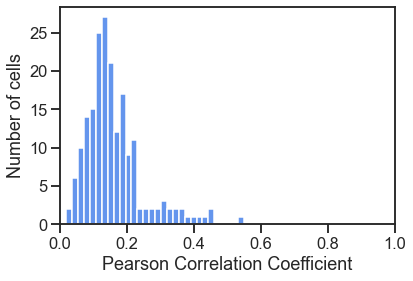

In [781]:
CorrThrslhd = 0.50 #choose threshold

Pll=plt.hist(result_array_correlation2, bins = 30, color='cornflowerblue')
plt.ylabel('Number of cells')
plt.xlabel('Pearson Correlation Coefficient')
# plt.axvline(CorrThrslhd, color= 'firebrick', alpha = 0.5)
plt.xlim(0,1)
# path10 = os.path.join(saveDataFramePath, "Correlation_Coeff_Plane_1.png")
# plt.savefig(path10, transparent = True, dpi = 300, bbox_inches='tight')

# Calculate Fluorescence distribution of GCaMP and tdTomato - Non scaled arrays

In [782]:
def GetFluoMeanValueDistribution (array, lthresh, hthresh, Fluorophore):
    cellsmean= array.mean(1)
    cellsmean= cellsmean[...,lthresh:hthresh]
    cellsmean= cellsmean.mean(2)
    cellsmean= cellsmean.mean(1)
    cellsmean.shape

    Pm=plt.hist(cellsmean, bins = 40, color = Fluorophore)
    #plt.title(title)
    plt.xlabel('Fluoresence value')
    plt.ylabel('number of cells')

# Same but normalize signal

Text(0, 0.5, 'number of cells')

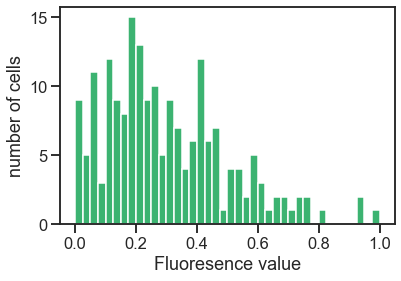

In [783]:
FluoDistr= filteredDataArray_Fluo.mean(2)
FluoDistr= FluoDistr[...,23:45]
FluoDistr= FluoDistr.mean(2)
FluoDistr= FluoDistr.mean(1)
FluoDistr.shape

FluoDistr = FluoDistr[FluoDistr >= 0]
FluoDistrNorm = preprocessing.minmax_scale(FluoDistr, feature_range=(0, 1),axis=0, copy=True)

Pm=plt.hist(FluoDistrNorm, bins = 40, color = 'mediumseagreen')
plt.xlabel('Fluoresence value')
plt.ylabel('number of cells')

# path10 = os.path.join(saveDataFramePath, "Distribution_GCaMP_baseline_Plane_1.png")
# plt.savefig(path10, transparent = True, dpi = 300, bbox_inches='tight')

In [784]:
filteredDataArray_Fluo_red.shape

(193, 4, 34, 100)

Text(0, 0.5, 'number of cells')

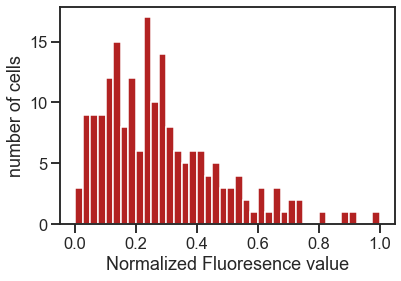

In [785]:
RedThrslhdNorm = 0.53

FluoDistr= filteredDataArray_Fluo_red.mean(2)
FluoDistr= FluoDistr[...,0:23]
FluoDistr= FluoDistr.mean(2)
FluoDistr= FluoDistr.mean(1)
FluoDistr.shape

# FluoDistr = FluoDistr[FluoDistr >= 0]
FluoDistrNorm = preprocessing.minmax_scale(FluoDistr, feature_range=(0, 1),axis=0, copy=True)

Pm=plt.hist(FluoDistrNorm, bins = 40, color = 'firebrick')
#plt.axvline(RedThrslhdNorm, color = 'firebrick', alpha = 0.5)
plt.xlabel('Normalized Fluoresence value')
plt.ylabel('number of cells')

# path12 = os.path.join(saveDataFramePath, "Distribution_tdTomato_baseline_Plane_1.png")
# plt.savefig(path12, transparent = True, dpi = 300, bbox_inches='tight')

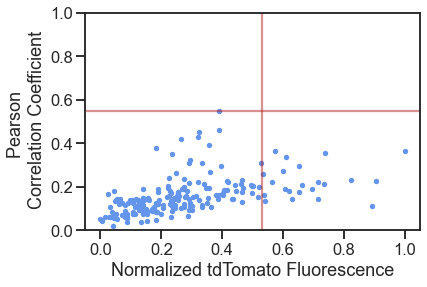

In [786]:
plt.scatter(x=FluoDistrNorm, y=result_array_correlation2, c='cornflowerblue', s=15)
plt.ylabel('Pearson \n Correlation Coefficient')
plt.xlabel('Normalized tdTomato Fluorescence')
plt.ylim(0,1)
plt.axvline(RedThrslhdNorm, color = 'firebrick', alpha = 0.5)
plt.axhline(0.55, color = 'firebrick', alpha = 0.5)

path12 = os.path.join(saveDataFramePath, "Distribution_Corr_tdTom.png")
plt.savefig(path12, transparent = True, dpi = 300, bbox_inches='tight')

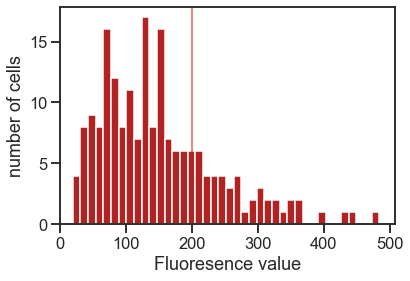

In [787]:
GetFluoMeanValueDistribution(array=filteredDataArray_Fluo_red,lthresh=0, hthresh=45, Fluorophore="firebrick")
plt.xlim(0)
plt.axvline(200, color = 'firebrick', alpha = 0.5)

# Get tdTomato positive cells list!

In [788]:
# Necessary to do it on all cells (aka with false positives)
Redcellsmean= DataArray_Fadj_Fluo_Red.mean(2)
Redcellsmean= Redcellsmean[...,0:23]
Redcellsmean= Redcellsmean.mean(2)
Redcellsmean= Redcellsmean.mean(1)

In [789]:
Redcellsmean.shape

(314,)

In [790]:
RedCellId = []
RedCellProb = []
for cell in range (numCells):
    RedCellId1= DF.loc [DF.cellID==cell, 'cellID'].values
    RedCellProb1= DF.loc [DF.cellID==cell, 'cellProbBinary'].values
    RedCellId.append(RedCellId1.reshape(40,numOdors,numFramesOdorTrial)[None])
    RedCellProb.append(RedCellProb1.reshape(40,numOdors,numFramesOdorTrial)[None])

RedCellId = np.concatenate(RedCellId,0)
RedCellProb = np.concatenate(RedCellProb,0)

RedCellId = RedCellId[:,0,0,0]
RedCellProb = RedCellProb[:,0,0,0]

print(f'4D matrices are the same size: {RedCellId.shape==Redcellsmean.shape}')

4D matrices are the same size: True


In [791]:
#np.range to check  

result_array_correlationforRED = np.zeros((numCells,numOdors,numTrials))
for cell in range(numCells):
    for odor in range(numOdors):
        for trial in range(numTrials):
            result_array_correlationforRED[cell,odor,trial] = stats.pearsonr(DataArray_Fadj_Fluo[cell,odor,trial,:],DataArray_Fadj_Fluo_Red[cell,odor,trial,:])[0] #0 = r, 1= p-value
result_array_correlationforRED.shape

result_array_correlationforRED1 = result_array_correlationforRED.mean(2)
result_array_correlationforRED2 = result_array_correlationforRED1.mean(1)
result_array_correlationforRED2.shape

(314,)

In [792]:
RedCellList = pd.DataFrame(np.vstack((RedCellId[:], RedCellProb[:], Redcellsmean[:], result_array_correlationforRED2[:]))).T

In [793]:
# Put Fluorescence intensity threshold to select true positive tdTomato cells
RedThrslhd = 300

RedCellListFinal = RedCellList[RedCellList[1] == 1.0]
RedCellListFinal = RedCellListFinal[RedCellListFinal[2] >= RedThrslhd]
RedCellListFinal = RedCellListFinal[RedCellListFinal[3] <= CorrThrslhd]
RedCellListFinal = RedCellListFinal.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo', 3:'CorrelationGreenRed'}, axis=1)
RedCellListFinal

cellID  GreencellProb  RedcellMeanFluo  CorrelationGreenRed
1       1.0            1.0       352.161627             0.221235
8       8.0            1.0       359.969135             0.215102
12     12.0            1.0       361.979339             0.353926
27     27.0            1.0       302.184163             0.336111
28     28.0            1.0       484.257982             0.366077
29     29.0            1.0       327.011724             0.209964
42     42.0            1.0       439.748306             0.229018
52     52.0            1.0       312.433781             0.146000
59     59.0            1.0       401.719942             0.230407
73     73.0            1.0       322.933077             0.293603
93     93.0            1.0       300.690312             0.188638
101   101.0            1.0       307.077715             0.182337
136   136.0            1.0       433.476477             0.111458
157   157.0            1.0       322.929734             0.177752
186   186.0            1.0       341.836247             0.192177
212   212.0            1.0       352.076626             0.141965

In [794]:
# Create list of Redcells to keep from above
RedcellsToKeep = RedCellListFinal['cellID']
RedcellsToKeep = RedcellsToKeep.to_numpy()
RedcellsToKeep = RedcellsToKeep.astype(int)

In [795]:
DataArray_Red = DataArray_Fadj[RedcellsToKeep,:,:,:]
DataArray_Red.shape

(16, 4, 34, 100)

In [796]:
GreenCellListFinal = RedCellList[RedCellList[1] == 1.0]
GreenCellListFinal = GreenCellListFinal[GreenCellListFinal[2] < RedThrslhd]
GreenCellListFinal = GreenCellListFinal.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo'}, axis=1)

In [797]:
GreencellsToKeep = GreenCellListFinal['cellID']
GreencellsToKeep = GreencellsToKeep.to_numpy()
GreencellsToKeep = GreencellsToKeep.astype(int)

In [798]:
DataArray_Green = DataArray_Fadj[GreencellsToKeep,:,:,:]
DataArray_Green.shape

(177, 4, 34, 100)

In [799]:
filteredDataArray.shape

(193, 4, 34, 100)

In [800]:
DataArray_Green = DataArray_Green.transpose(0,2,1,3)
DataArray_Red = DataArray_Red.transpose(0,2,1,3)
filteredDataArray = filteredDataArray.transpose(0,2,1,3)

# Final matrices to work with - cells x trials x stimuli x time

In [ ]:
filteredDataArraypath = os.path.join(saveDataFramePath, "filteredDataArray.npy")
DataArray_Redpath = os.path.join(saveDataFramePath, "DataArray_Red.npy")
DataArray_Greenpath = os.path.join(saveDataFramePath, "DataArray_Green.npy")
RedCellListSavepath = os.path.join(saveDataFramePath, "RedCellList.npy")

In [ ]:
from numpy import save
#All Cells 
                            #filteredDataArray
save(file = filteredDataArraypath, arr= filteredDataArray)

#Only Red cells
                            #DataArray_Red
save(file = DataArray_Redpath, arr= DataArray_Red)

#Only Green non-Red cells
                            #DataArray_Green
save(file = DataArray_Greenpath, arr= DataArray_Green)

#List of tdTomato cells
                            #RedCellList
save(file = RedCellListSavepath, arr= RedCellListFinal)